# Profiling your python code

_Ivan Oreshnikov <ioreshnikov@tuebingen.mpg.de> on August 29, 2019_

<img src="wood.jpg" title="Yep, it's wood" style="width: 500px"/>

## Introduction

> Programmers waste enormous amounts of time thinking about, or worrying about, the speed of noncritical parts of their programs, and these attempts at efficiency actually have a strong negative impact when debugging and maintenance are considered. We should forget about small efficiencies, say about 97% of the time: premature optimization is the root of all evil. Yet we should not pass up our opportunities in that critical 3%.
>
> _Donald Knuth_

Congratulations! You've finally written a prototype, and it is working, and it is almost bug free, and it is even somewhat readable and relatively straightforwad. There is only one drawback -- the code is slow. At this point it might be good idea to optimize your code. It might not be -- after all, almost always the optimizations your make to your code comes at a price of losing in readability. But if you decide to optimize, how do you know where to start?

This is when you need a profiler. To proceed further we would need a code example, and for a proper illustration it should be a relatively complicated one.

## n-body problem

As an illustration let's consider the code that integrates an n-body problem. The problem statement is the following: suppose you have a ensemble of massive particles that gravitationally interact with each other; given the initial positions and velocities of the particle how can you predict the evolution of the system? 

To be more precise, let's assume that we have a system of $N$ vectorial second-order differential equations
$$
    \frac{d^2 \vec r_i}{dt^2} = 
      \sum \limits_{j = 0 \\ j \ne i}^{N} 
        \frac{
          (\vec r_i - \vec r_j)
        }{
          \left| \vec r_i - \vec r_j \right|^3
        }
$$
We are dropping the masses and the gravitational constant for simplicity's sake; there guaranteed to be a system of measurement where this system of equations is exact. We also know the initial condition of the system
$$
    \vec r_i(t = 0) = \vec r_{i0} 
    \\
    \left. \frac{d \vec r_i}{dt} \right|_{t = 0} = \vec v_{i0}
$$

Let us define the velocity of the $i$-th particle as $\vec v_i = d \vec r_i / dt$. For a set of positions and velocities of the particles we then can write a system of $2 N$ vectorial first-order differential equations
$$
    \frac{d \vec r_i}{dt} = \vec v_i
    \\
    \frac{d \vec v_i}{dt} = 
      \sum \limits_{j = 0 \\ j \ne i}^{N} 
        \frac{
          (\vec r_i - \vec r_j)
        }{
          \left| \vec r_i - \vec r_j \right|^3
        }       
$$
This is, in essence, a system of the following structure
$$
    \frac{d \vec x}{dt} = f(t, \vec x)
$$
and there are a lot of sophisticated numerical algorithms for solving the initial value problem for such a system. But we, of course, are going to use the most simple one of them -- the Euler method. The idea is to iteratively update our estimations in the following manner
$$
    \vec x(t_{n + 1}) = \vec x(t_{n}) + f(t, \vec x(t_n)) (t_{n + 1} - t_{n})
$$
using very fine steps in time $t_{n + 1} - t_{n}$, until we reach a desired moment in the simulation.

The general idea should be clear. Let's try and implement the numerical method. We will need several function, but we will start with a function that creates a cloud of $N$ randomly positioned particles at rest.

In [1]:
import numpy


def random_state(n):
    x = numpy.random.randn(n)
    y = numpy.random.randn(n)
    z = numpy.random.randn(n)
    px = numpy.zeros(n)
    py = numpy.zeros(n)
    pz = numpy.zeros(n)

    return numpy.concatenate((x, y, z, px, py, pz))

Next, we need a function that evaluates the right hand's side of the system of equations.

In [2]:
def rhs(t, s):
    # Instantiate an empty vector for the result.
    n = int(len(s) / 6)
    ds = numpy.zeros(len(s))

    # Split the state in the coordinate and the velocity part.
    r = s[:3*n]
    v = s[3*n:]

    # We calcualte RHS for the coordinate part by simply copying the
    # appropriate velocities.
    for i in range(n):
        ds[i] = v[i]
        ds[i + n] = v[i + n]
        ds[i + 2*n] = v[i + 2*n]

    # Now the velocity part or RHS. We iterate over each particle in
    # the cloud.
    for i in range(n):
        # Take the coordinates of the i-th particle.
        xi = r[i]
        yi = r[i + n]
        zi = r[i + 2*n]

        # And then for every other particle in the cloud.
        for j in range(n):
            if j == i:
                continue

            # We take coordinates of the j-th particle. 
            xj = r[j]
            yj = r[j + n]
            zj = r[j + 2*n]

            # Calculate the cubed distance between the particles.
            dx = xi - xj
            dy = yi - yj
            dz = zi - zj
            d = (dx**2 + dy**2 + dz**2 + 1E-6) ** (3/2)

            # And then update the appropriate parts of the RHS vector.
            ds[i + 3*n] += dx / d
            ds[i + 4*n] += dy / d
            ds[i + 5*n] += dz / d

    return ds

Euler method itself is trivial

In [3]:
def euler(t0, t1, x0, rhs, dt):
    t = t0
    x = x0

    while t < t1:
        x += rhs(t, x) * dt
        t += dt

    return x

Finally, to do some measurements we will need a benchmark function. Let's simply integrate a cloud of $N$ particles for 100 iterations.

In [4]:
def nbody(n):
    s0 = random_state(n)
    s1 = euler(0, 1, s0, rhs, 1E-2)
    return s1

## Simple benchmarking

In [5]:
import time

start = time.time()
for _ in range(1000):
    100**2
stop = time.time()
stop - start

0.00017452239990234375

The most simple way to measure the performance of your code is to measure the execution time. In python you can do it with help of `timeit` method.

In [6]:
import timeit

timeit.timeit("100**100", number=1000)

0.0009539849997963756

This functionality is even supported in `jupyter` as a magic command!

In [7]:
%timeit -n 1000 -r 10 100**100

The slowest run took 10.22 times longer than the fastest. This could mean that an intermediate result is being cached.
2.14 µs ± 2.63 µs per loop (mean ± std. dev. of 10 runs, 1000 loops each)


In [8]:
timeit.timeit("""
xs = []
for x in range(1000):
    xs.append(x**2)
""", number=10000)

4.085585338994861

In [11]:
import random

In [13]:
timeit.timeit("import random; xs = [random.choice([True, 100]) for x in range(1000)]", number=10000)

8.250687594001647

So let's try and measure the execution time of our `nbody` function for different values of `n`.

In [14]:
%timeit -n 1 -r 1 nbody(1)

1.88 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [15]:
%timeit -n 1 -r 1 nbody(10)

56 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [16]:
%timeit -n 1 -r 1 nbody(100)

3.6 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


Ok, it's getting slower with more particles you add. But how much slower? Let's try to plot the execution time as a function of number of particles.

<IPython.core.display.Javascript object>


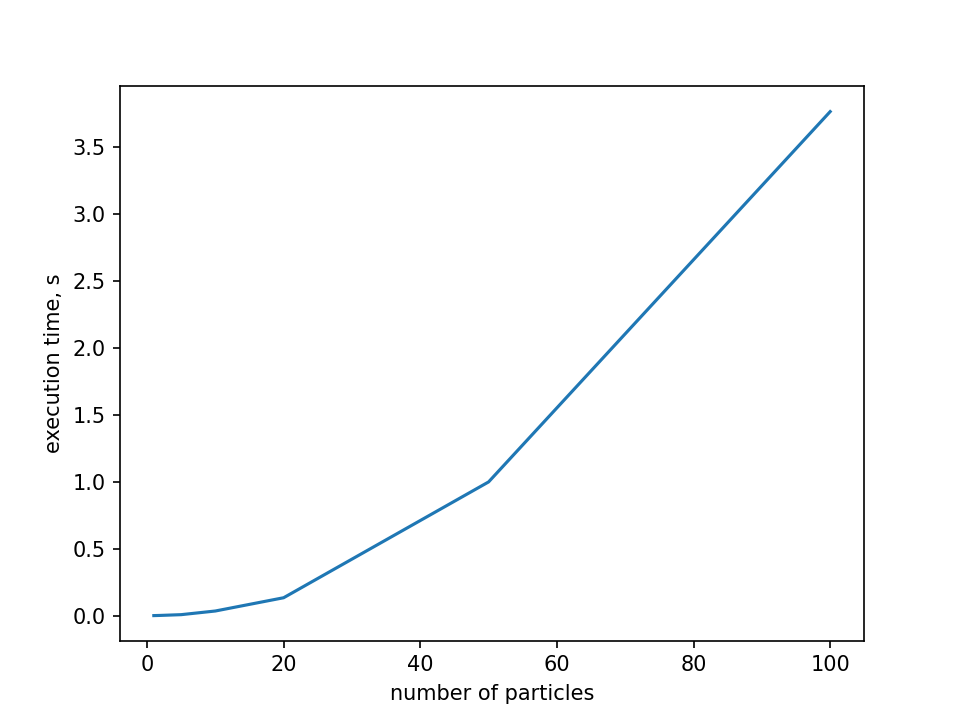

In [17]:
%matplotlib notebook
import matplotlib.pyplot as plot

ns = [1, 2, 5, 10, 20, 50, 100]
ts = []
for n in ns:
    t = timeit.timeit("nbody(n)", setup="from __main__ import nbody, n", number=1)
    ts.append(t)
    
plot.figure()
plot.plot(ns, ts)
plot.xlabel("number of particles")
plot.ylabel("execution time, s")
plot.show()

Oh. It's getting pretty slow. Let's try and use a more fine-grained tool to figure out where this slowdown is coming from.

## Profiling

For a detailed analysis of your program performance you need a speacialized tool called _profiler_. Profiler, essentially, is simply measuring how much time every instruction take, how often is it called, accumulates the statistics over the program run and then presents it to you. Python comes with two profilers out of the box: `cProfiler` and `profiler`. The first one is a recommended option for a general audience.

In [18]:
import cProfile

cProfile.run("nbody(100)")

         415 function calls in 3.962 seconds

   Ordered by: standard name

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.000    0.000    3.962    3.962 1000782447.py:1(nbody)
      100    3.955    0.040    3.956    0.040 2082565857.py:1(rhs)
        1    0.000    0.000    0.001    0.001 365373034.py:4(random_state)
        1    0.005    0.005    3.961    3.961 3977450614.py:1(euler)
        1    0.000    0.000    0.000    0.000 <__array_function__ internals>:2(concatenate)
        1    0.000    0.000    3.962    3.962 <string>:1(<module>)
        1    0.000    0.000    0.000    0.000 multiarray.py:148(concatenate)
        1    0.000    0.000    3.962    3.962 {built-in method builtins.exec}
      200    0.000    0.000    0.000    0.000 {built-in method builtins.len}
        1    0.000    0.000    0.000    0.000 {built-in method numpy.core._multiarray_umath.implement_array_function}
      103    0.001    0.000    0.001    0.000 {built-in method 

By default the result is not ordered. Let's order it by the cumulative time spent executing a function.

In [12]:
cProfile.run("nbody(100)", sort="cumtime")

         415 function calls in 2.715 seconds

   Ordered by: cumulative time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.000    0.000    2.715    2.715 {built-in method builtins.exec}
        1    0.000    0.000    2.715    2.715 <string>:1(<module>)
        1    0.000    0.000    2.715    2.715 <ipython-input-4-cadd089810ab>:1(nbody)
        1    0.003    0.003    2.715    2.715 <ipython-input-3-38cd95071fab>:1(euler)
      100    2.711    0.027    2.712    0.027 <ipython-input-2-2e7f03fc2825>:1(rhs)
      103    0.001    0.000    0.001    0.000 {built-in method numpy.zeros}
      200    0.000    0.000    0.000    0.000 {built-in method builtins.len}
        1    0.000    0.000    0.000    0.000 <ipython-input-1-9eec4da85033>:4(random_state)
        3    0.000    0.000    0.000    0.000 {method 'randn' of 'numpy.random.mtrand.RandomState' objects}
        1    0.000    0.000    0.000    0.000 <__array_function__ internals>:2(concatenate)
   

Ok, that's something. We can see, that the entire execution took a little bit over 2.5 seconds, and that most of that time were spent evaluating the `rhs`. But we could have guessed it. Are there any problematic moments in `rhs` that we could easily optimize? 

To answer this question we need a profiler that operates in line-by-line fashion. Unfortunately, neither `cProfile` nor `profile` can do that. Thankfully, there is a profiler that was written to do exactly that! Welcome [line_profiler](https://github.com/rkern/line_profiler).

In [19]:
import line_profiler

ModuleNotFoundError: No module named 'line_profiler'

In [14]:
from line_profiler import LineProfiler

profiler = LineProfiler()
profiler.add_function(rhs)
profiler.run("nbody(100)")
profiler.print_stats()

Timer unit: 1e-06 s

Total time: 15.4377 s
File: <ipython-input-3-2e7f03fc2825>
Function: rhs at line 1

Line #      Hits         Time  Per Hit   % Time  Line Contents
     1                                           def rhs(t, s):
     2                                               # Instantiate an empty vector for the result.
     3       100        508.0      5.1      0.0      n = int(len(s) / 6)
     4       100       1333.0     13.3      0.0      ds = numpy.zeros(len(s))
     5                                           
     6                                               # Split the state in the coordinate and the velocity part.
     7       100        390.0      3.9      0.0      r = s[:3*n]
     8       100        170.0      1.7      0.0      v = s[3*n:]
     9                                           
    10                                               # We calcualte RHS for the coordinate part by simply copying the
    11                                               # app

That's much better! Unsurprisingly, the slowest part of the function is calculating the cubed distance between the particles. Second after that is division by said distance. Those are arithmetic operations that we are absolutely have to do, and we have to do them for each and every particle pair.

However, we don't have to do them in a simple python loop. Since we are already using numpy to store the data, why don't take an advantange in numpy's ability to efficiently broadcast the operations over the arrays.

## A vectorized solution

To take an advantage of numpy's optimization we have to replace all the operations we do with individual vector components with operations over the whole vectors. This maneuver is called _vectorizing_ , and a function written in such a manner is known as a _vectorized_ function. Unfortunately, it's easier said than done. Vectorizing a function is a creative task. It's not alway obvious how to approach it, it's not alway possible. And there is also a chance that the vectorized function will look like an unreadable mess, but that mostly depends on what the original function looked like.

A vectorized version of `rhs` can be found below.

In [15]:
def rhs_vec(t, s):
    # Instantiate an empty vector for the result.
    n = int(len(s) / 6)
    ds = numpy.zeros(len(s))

    # Split the state in the coordinate and the velocity part.
    r = s[:3*n]
    v = s[3*n:]

    # Again, simply copyint the velocities into the coordinate part of
    # the RHS vector.
    ds[:3*n] = v

    # Split the coordinate into vector of xs, ys, and zs.
    x = r[:n]
    y = r[n:2*n]
    z = r[2*n:]

    # Form couples of square matrices by repeating the coordinate
    # vectors N times row-wise (for xi, yi, zi) and column-wise (for
    # xj, yj, zj).
    xi, xj = numpy.meshgrid(x, x)
    yi, yj = numpy.meshgrid(y, y)
    zi, zj = numpy.meshgrid(z, z)

    # Then the difference between xi and xj will give us a square
    # matrix of pariwise coordinate differences between i-th and j-th
    # particles. There will be zeros in the diagonals.
    dx = xi - xj
    dy = yi - yj
    dz = zi - zj

    # Calcualte the matrix of pariwise cubed distances.
    d = (dx**2 + dy**2 + dz**2 + 1E-6) ** (3/2)

    # Finally, form the individual parts of the coordinate RHS vector
    # by dividing dx, dy and dz over d, but only in the nondiagonal
    # elements, and then summing the across the rows -- this is,
    # essentially, the inner loop of our unvectorized implementation.
    nondiagonal = (d != 0)
    dsx = numpy.sum(numpy.divide(dx, d, where=nondiagonal), axis=0)
    dsy = numpy.sum(numpy.divide(dy, d, where=nondiagonal), axis=0)
    dsz = numpy.sum(numpy.divide(dz, d, where=nondiagonal), axis=0)

    # Put the coordiante parts together.
    ds[3*n:4*n] = dsx
    ds[4*n:5*n] = dsy
    ds[5*n:6*n] = dsz

    return ds

For comparison purposes we will define a separate benchmarking function.

In [16]:
def nbody_vec(n):
    s0 = random_state(n)
    s1 = euler(0, 1, s0, rhs_vec, 1E-2)
    return s1

Ok, let's measure our new performace!

In [17]:
%timeit -n 1 -r 1 nbody_vec(100)

124 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


Approximately 120 milliseconds compared to approximately 2.5 seconds. Not bad! Let's take a look at the profiling results.

In [18]:
profiler = LineProfiler()
profiler.add_function(rhs_vec)
profiler.run("nbody_vec(100)")
profiler.print_stats()

Timer unit: 1e-06 s

Total time: 0.137032 s
File: <ipython-input-15-b385663db948>
Function: rhs_vec at line 1

Line #      Hits         Time  Per Hit   % Time  Line Contents
     1                                           def rhs_vec(t, s):
     2                                               # Instantiate an empty vector for the result.
     3       100        510.0      5.1      0.4      n = int(len(s) / 6)
     4       100       1079.0     10.8      0.8      ds = numpy.zeros(len(s))
     5                                           
     6                                               # Split the state in the coordinate and the velocity part.
     7       100        305.0      3.0      0.2      r = s[:3*n]
     8       100        199.0      2.0      0.1      v = s[3*n:]
     9                                           
    10                                               # Again, simply copyint the velocities into the coordinate part of
    11                                        

Finally, let's take a look on how the both solutions scale with respecto to number of particles in a cloud.

<IPython.core.display.Javascript object>


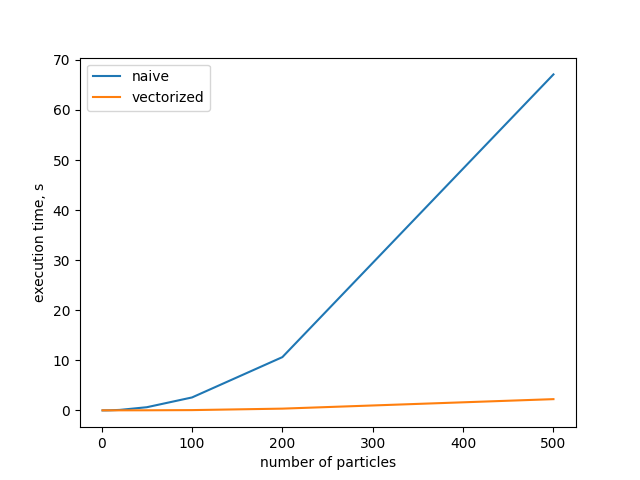

In [18]:
ns = [1, 2, 5, 10, 20, 50, 100, 200, 500]
ts = []
tvs = []
for n in ns:
    t = timeit.timeit("nbody(n)", setup="from __main__ import nbody, n", number=1)
    tv = timeit.timeit("nbody_vec(n)", setup="from __main__ import nbody_vec, n", number=1)
    ts.append(t)
    tvs.append(tv)
    
plot.figure()
plot.plot(ns, ts, label="naive")
plot.plot(ns, tvs, label="vectorized")
plot.legend()
plot.xlabel("number of particles")
plot.ylabel("execution time, s")
plot.show()

## Supplementary materials

1. https://docs.python.org/3/library/profile.html -- the reference for the standard profilers.
2. https://github.com/rkern/line_profiler -- `line_profiler` repo. The only documentaion we have is a README file.